In [20]:
import numpy as np
import plotly.graph_objs as go
import pandas as pd
from rdkit import Chem
from matchms.importing import load_from_msp
from matchms.logging_functions import set_matchms_logger_level

from utils import is_spectrum_for_compound, append_classes
from plotting import scatterplot_matplotlib

set_matchms_logger_level('ERROR')

In [21]:
matchms_scores = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.01_1%I_all_peaks_with_0s.tsv", sep="\t")

matchms_scores = matchms_scores[matchms_scores.apply(lambda x: is_spectrum_for_compound(x['query'], x['reference']), axis=1)]

molecules = Chem.SDMolSupplier("../../data/RECETOX_GC-EI-MS_20201028.sdf")

predicted_spectra = list(load_from_msp("../data/filtered/simulated_matchms_filter_1%I_all_peaks.msp"))
spectra_metadata = pd.DataFrame.from_dict([x.metadata for x in predicted_spectra])
spectra_metadata.rename(columns={'compound_name': 'query'}, inplace=True)

reference_spectra = list(load_from_msp("../data/experimental/RECETOX_GC-EI_MS_20201028.msp"))
reference_spectra_metadata = pd.DataFrame.from_dict([x.metadata for x in reference_spectra])
reference_spectra_metadata.rename(columns={'compound_name': 'reference'}, inplace=True)


In [22]:
merged = matchms_scores.merge(spectra_metadata, on="query", how="inner")
merged.rename(columns={'num_peaks': 'n_peaks_query'}, inplace=True)

merged = merged.merge(reference_spectra_metadata, on="reference", how="inner")
merged.rename(columns={'num_peaks': 'n_peaks_reference'}, inplace=True)

In [23]:
merged['CosineHungarian_0.01_0.0_1.0_matches'] = pd.to_numeric(merged['CosineHungarian_0.01_0.0_1.0_matches'], errors='coerce')
merged['n_peaks_query'] = pd.to_numeric(merged['n_peaks_query'], errors='coerce')
merged['n_peaks_reference'] = pd.to_numeric(merged['n_peaks_reference'], errors='coerce')

merged['FractionQuery'] = merged['CosineHungarian_0.01_0.0_1.0_matches'] / merged['n_peaks_query']
merged['FractionReference'] = merged['CosineHungarian_0.01_0.0_1.0_matches'] / merged['n_peaks_reference']

In [24]:
merged = append_classes(merged, "query")

In [35]:
# Create a scatter plot
def scatterplot_plotly(df, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['CosineHungarian_0.01_0.0_1.0_scores'],
        y=df['CosineHungarian_0.01_0.0_1.0_matches'],
        mode='markers+text',
        marker=dict(
            size=df['FractionQuery'] * 20,  # Adjust the size scaling factor as needed
            color=df['FractionReference'],
            colorscale='Viridis',  # change the colorscale as needed
            colorbar=dict(title='Reference Matched %'),
            cmin=0,  # Set the minimum color limit
            cmax=1,  # Set the maximum color limit
            opacity=0.5
        ),
        # text=df['reference'],
        # textposition='top center',
        name='Matched Ions'
    ))
    fig.update_layout(
        xaxis_title='Score',
        yaxis_title='Matches',
        title_text=title,
        xaxis=dict(range=[0, 1])  # Set the x-axis limits
    )
    fig.show()
    return fig

In [38]:
grouped_df = merged.groupby('superclass')
for group in grouped_df.groups:
    subset = grouped_df.get_group(group)
    if subset.shape[0] > 10:
        scatterplot_plotly(grouped_df.get_group(group), group).write_image(f"scatterplot_{group}.png")

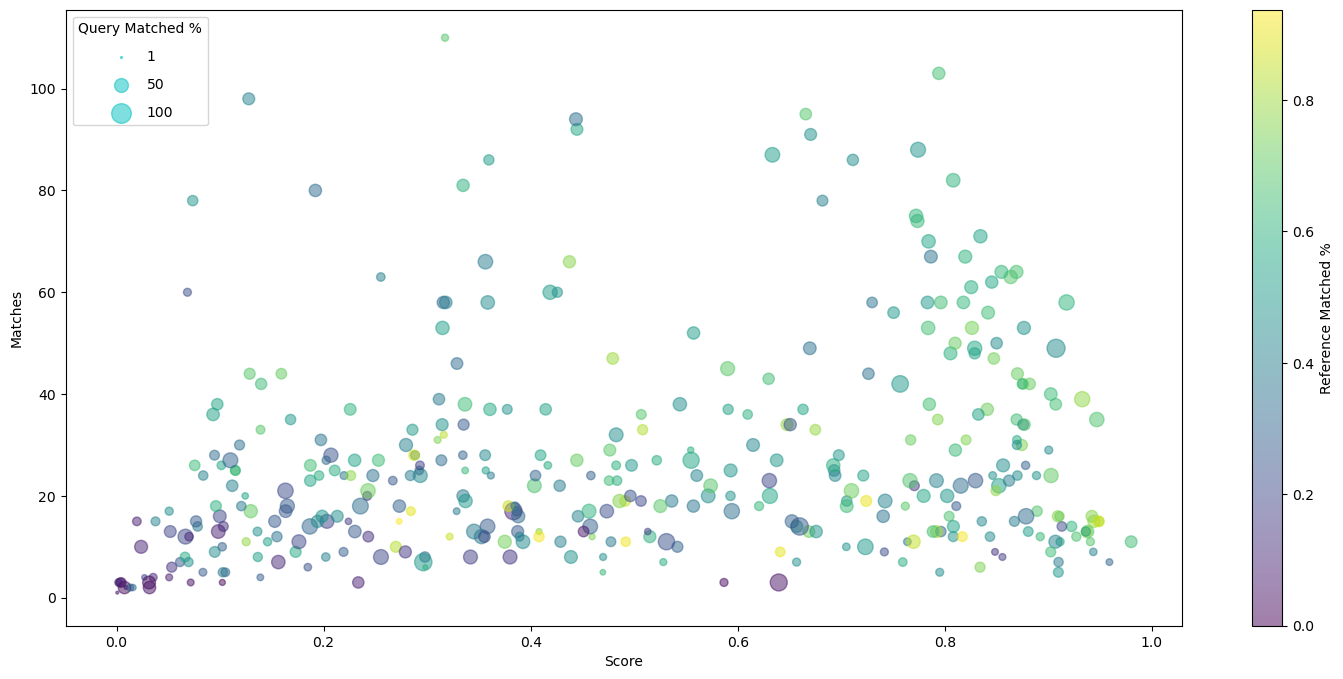

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot
scatterplot_matplotlib(merged)
#plt.savefig("scatter_plot.png")